### В данном ноутбуке мы будем подходить к задаче определения качества вина как в задаче классификации.

## Качество вина 

Задача заключается в предсказании качества вина на основе его химических характеристик. 

Числовой датасет. Включает себя информацию о химических характеристик вина и его оценку по шкале от 0 до 10. Состоит из 4898 наблюдений. 

[1. Описание датасета](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

[2. Расположение .csv файла](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) 

#### Входные переменные (на основе физико-химических тестов):

1 - **[fixed acidity]** фиксированная кислотность  

2 - **[volatile acidity]** летучая кислотность  

3 - **[citric acid]** лимонная кислота  

4 - **[residual sugar]** остаточный сахар  

5 - **[chlorides]** хлориды  

6 - **[free sulfur dioxide]**	свободный диоксид серы  

7 -  **[total sulfur dioxide]** общий диоксид серы  

8 - **[density]** плотность  

9 - **[рН]**  

10 - **[sulphates]** сульфаты  

11 - **[alcohol]** алкоголь  

-----------------------------------------------
#### Выходная переменная (на основе сенсорных данных):  

12 - **[quality]** качество (оценка от 0 до 10)

In [1]:
# download dataset
!wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

--2021-07-28 12:01:14--  http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv.1’

winequality-white.c 100%[===================>] 258.23K   412KB/s    in 0.6s    

2021-07-28 12:01:16 (412 KB/s) - ‘winequality-white.csv.1’ saved [264426/264426]



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE 

In [5]:
import lightgbm as lgbm
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

In [6]:
white_wine_df = pd.read_csv('winequality-white.csv',sep=';')
white_wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [7]:
white_wine_df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [8]:
#Счет начинается со значения 3. Сместим значение целевого параметра на 3 единицы вниз.
# это уменьшит к-во классов исключив те для которых вообще нет примеров.

white_wine_df['quality']= white_wine_df['quality']-3 

In [9]:
white_wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,2.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,2.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,3.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,3.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,6.000000


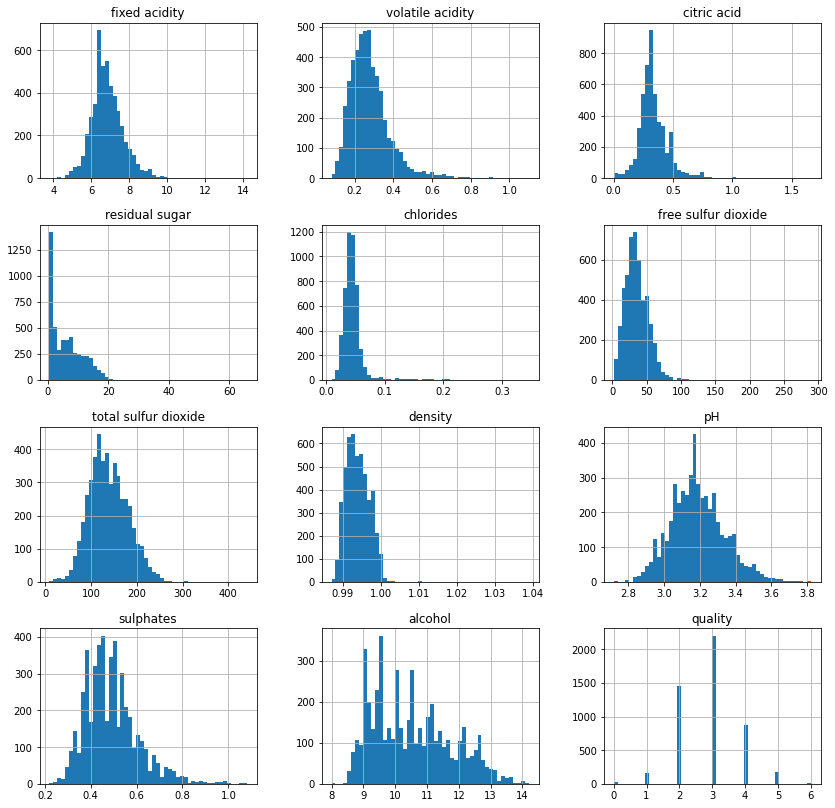

In [10]:
white_wine_df.hist(figsize=(14,14), bins=50, grid=True);

По графикам нетрудно определить, что в данных имеются выбросы. 

Выбросы могут негативно отразиться на качестве обучения модели.
Постараемся от них избавиться, установив вручную максимальное значение для параеметров, с для которых имеются значения с сильным отклоенеием от прочих парамеров.

In [11]:
# white_wine_df.loc['free sulfur dioxide'] = white_wine_df.loc[(white_wine_df['free sulfur dioxide']>130)] = 130

white_wine_df.loc[(white_wine_df['free sulfur dioxide'] > 100),'free sulfur dioxide'] = 100

white_wine_df.loc[(white_wine_df['total sulfur dioxide'] > 300),'total sulfur dioxide'] = 300

white_wine_df.loc[(white_wine_df['residual sugar'] > 25),'residual sugar'] = 25

white_wine_df.loc[(white_wine_df['density'] > 1.01),'density'] = 1.01

white_wine_df.loc[(white_wine_df['chlorides'] > 0.2),'chlorides'] = 0.2

# white_wine_df.loc[(white_wine_df['free sulfur dioxide'] > 150)]

In [12]:
x_data = white_wine_df.iloc[:,:-1]
y_data = white_wine_df.iloc[:,-1]

In [13]:
input_shape = x_data.shape[1]
print('К-во признаков:', input_shape)

К-во признаков: 11


In [14]:
# Получим список признаков. 
numerical = [col for col, value in x_data.iteritems()]
numerical

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [15]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print()
    print(pd.crosstab(y_test_true, y_test_pred))

In [16]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [17]:
y_data.value_counts()

3    2198
2    1457
4     880
5     175
1     163
0      20
6       5
Name: quality, dtype: int64

Видно, что к-во разных классов не одинаково.

Что логичто, т.к. как очень хорошее вино, так и вино откровенно плохого к-ва встречается редко. 

В этом ноутбуке мы разделим датасет только на тренировочную и тестовую выборки. Валлидационную использовать не будем. 

In [18]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1,test_size=0.2,stratify=y_data)


In [19]:
preprocessor =  make_column_transformer(
                                        (StandardScaler(), numerical)# make_column_selector(dtype_include=np.number)),
                                       )

In [20]:
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [21]:
df = pd.DataFrame(columns=numerical)

for x in X_train:
    series_obj = pd.Series( x, index=df.columns )
    df = df.append(  series_obj, ignore_index=True)

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03
mean,-3.839450e-16,3.280372e-16,3.031436e-16,-1.481998e-17,-6.375529e-16,-1.989220e-17,-1.310420e-16,2.876031e-14,-8.871016e-16,1.328981e-17,2.730219e-16
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-3.661529e+00,-1.951737e+00,-2.757479e+00,-1.161911e+00,-1.756456e+00,-2.042295e+00,-3.067231e+00,-2.347042e+00,-3.115469e+00,-2.371721e+00,-2.042770e+00
25%,-6.645393e-01,-6.667754e-01,-5.430808e-01,-9.423631e-01,-4.687217e-01,-6.923648e-01,-7.170991e-01,-7.936206e-01,-6.568710e-01,-7.050009e-01,-8.218122e-01
50%,-6.514132e-02,-1.725594e-01,-1.330071e-01,-2.338218e-01,-1.348648e-01,-7.876004e-02,-9.989280e-02,-8.290514e-02,-5.883364e-02,-9.094619e-02,-8.923772e-02
75%,5.342567e-01,4.204999e-01,4.410961e-01,7.142263e-01,1.989922e-01,6.575657e-01,6.834844e-01,7.293411e-01,6.056524e-01,5.231085e-01,7.247339e-01
max,8.805949e+00,8.130271e+00,1.085697e+01,3.708063e+00,7.353069e+00,3.971032e+00,3.840732e+00,5.399757e+00,4.127428e+00,5.172380e+00,2.881759e+00


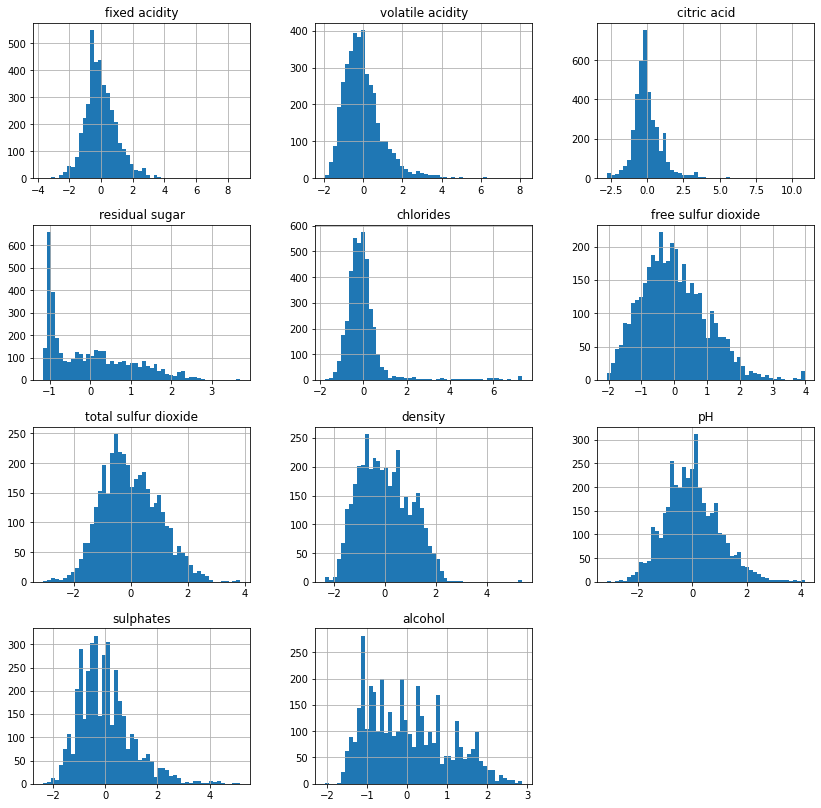

In [22]:
df.hist(figsize=(14,14), bins=50, grid=True);

Попытка уровнять к-во объектов разных классов не привела к улучшению качества. Только ухудшила его. 

Оставим данный код закомментрированным.

In [24]:
# print('Original dataset shape %s' % Counter(y_train))

# sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=1)

In [25]:
# X_train, y_train = sm.fit_resample(X_train, y_train)

# print('Resampled dataset shape %s' % Counter(y_train))

Задачу тардиционно постараемся решить двумя способами. 
Классическим и с помощью нейронных сетей.

### LGBMClassifier

In [26]:
%%time
model_lgbm = lgbm.LGBMClassifier (
                                 learning_rate = 0.01,
                                 random_state=21,
                                 max_depth=7,
                                 num_class=7,
                                 n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.91      0.08      0.14       130
           2       0.76      0.55      0.64      1166
           3       0.55      0.92      0.68      1758
           4       0.88      0.13      0.22       704
           5       1.00      0.05      0.10       140
           6       1.00      0.50      0.67         4

    accuracy                           0.60      3918
   macro avg       0.73      0.32      0.35      3918
weighted avg       0.70      0.60      0.54      3918

TEST

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        33
           2       0.66      0.52      0.58       291
           3       0.52      0.87      0.65       440
           4       0.65      0.09      0.15       176
           5       1.00      0.09      0.16        35
           

In [27]:
y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

In [28]:
print(y_test_pred[:10])
print(y_test[:10].values)

[2 3 3 3 3 2 3 3 3 3]
[2 3 4 4 3 2 3 3 3 3]


## NN

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense,InputLayer,BatchNormalization,Dropout
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.activations import relu, sigmoid, linear, tanh, elu,selu 
from tensorflow.keras.callbacks import EarlyStopping 

from tensorflow.keras.utils import to_categorical

In [31]:
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)

In [32]:
model = Sequential()
    # layers.BatchNormalization(input_shape=input_shape),
model.add(InputLayer(input_shape))
model.add(Dense(512, activation= 'relu'))
model.add(BatchNormalization())

model.add(Dense(256, activation= 'relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6144      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [33]:
from tensorflow.keras.optimizers import Adam

In [34]:
optimazer = Adam(learning_rate=0.0001)

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimazer,
              metrics=['accuracy'])

In [36]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [37]:
history = model.fit(X_train,y_train,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    batch_size=20,
                    verbose=1
                   )

Epoch 1/100
196/196 [==============================] - 2s 5ms/step - loss: 1.9775 - accuracy: 0.2994 - val_loss: 1.5865 - val_accuracy: 0.4898
Epoch 2/100
196/196 [==============================] - 1s 4ms/step - loss: 1.6781 - accuracy: 0.4278 - val_loss: 1.4406 - val_accuracy: 0.5122
Epoch 3/100
196/196 [==============================] - 1s 4ms/step - loss: 1.5274 - accuracy: 0.4862 - val_loss: 1.4443 - val_accuracy: 0.5173
Epoch 4/100
196/196 [==============================] - 1s 4ms/step - loss: 1.4201 - accuracy: 0.5385 - val_loss: 1.3908 - val_accuracy: 0.5306
Epoch 5/100
196/196 [==============================] - 1s 4ms/step - loss: 1.3531 - accuracy: 0.5480 - val_loss: 1.3392 - val_accuracy: 0.5408
Epoch 6/100
196/196 [==============================] - 1s 4ms/step - loss: 1.3010 - accuracy: 0.5656 - val_loss: 1.2966 - val_accuracy: 0.5439
Epoch 7/100
196/196 [==============================] - 1s 4ms/step - loss: 1.2194 - accuracy: 0.5827 - val_loss: 1.2344 - val_accuracy: 0.5704

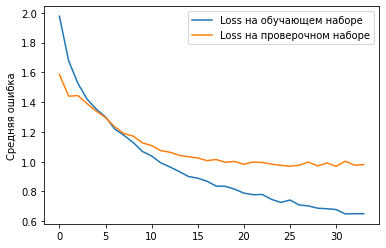

Loss: 0.984
accuracy: 0.630


In [38]:
plt.plot(history.history['loss'][:], 
         label='Loss на обучающем наборе')
plt.plot(history.history['val_loss'][:], 
         label='Loss на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

loss,accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss:.3f}')
print(f'accuracy: {accuracy:.3f}')

In [39]:
# Декодируем полученные значения.

y_train_pred = np.argmax(model.predict(X_train),axis=1)
y_test_pred = np.argmax(model.predict(X_test),axis=1)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.31      0.45        16
           1       0.88      0.46      0.61       130
           2       0.82      0.82      0.82      1166
           3       0.79      0.89      0.83      1758
           4       0.81      0.71      0.76       704
           5       0.86      0.49      0.63       140
           6       0.00      0.00      0.00         4

    accuracy                           0.80      3918
   macro avg       0.71      0.53      0.59      3918
weighted avg       0.81      0.80      0.80      3918

TEST

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.40      0.18      0.25        33
           2       0.62      0.69      0.66       291
           3       0.66      0.72      0.69       440
           4       0.59      0.52      0.55       176
           5       0.38      0.09      0.14        35
           

### Вывод: 

При решении задачи классификации при определении качества вина. Нейронная сеть дала качество предсказания нескольво выше чем LGBMClassifier.  